## Requirements 

In [7]:
#!pip install rdkit-pypi
#!pip install mordred
#!pip install tqdm

In [2]:
# Needed libraries
import pathlib
import pandas as pd 
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from moleculAR.moleculAR.preprocessing import smiles_cleaning as sc
from rdkit.Chem import rdMolDescriptors, MACCSkeys, RDKFingerprint, Descriptors
from moleculAR.moleculAR.preprocessing import featurization
from moleculAR.moleculAR.training import regression_models as rm
from moleculAR.moleculAR.preprocessing import feature_cleaning as fc
from rdkit import RDLogger


## 1. Data collection and cleaning

The first step when building a model is to collect the data that we need to train our model on.

Dataset source : https://www.researchgate.net/publication/289528451_Jean-Claude_Bradley_Open_Melting_Point_Dataset


In [3]:
# Set the data path and import the dataset
experimental_data_path = pathlib.Path("../data/BradleyMeltingPointDataset.xlsx")
raw_df = pd.read_excel(experimental_data_path)
raw_df.shape

(28645, 9)

In [4]:
raw_df.head(5)

,key,name,smiles,mpC,csid,link,source,donotuse,donotusebecause
0,1,"2-(2,4-dinitrobenzyl)pyridine",c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,64018,http://www.alfa.com/en/GP100W.pgm?DSSTK=B24192,Alfa Aesar,NaN,NaN
1,2,2-(1-piperidinyl)aniline,c1ccc(c(c1)N)N2CCCCC2,46.0,403764,http://www.alfa.com/en/GP100W.pgm?DSSTK=A13073,Alfa Aesar,NaN,NaN
2,3,2-(1-piperazinyl)pyrimidine,c1cnc(nc1)N2CCNCC2,33.0,80080,http://www.alfa.com/en/GP100W.pgm?DSSTK=L15884,Alfa Aesar,NaN,NaN
3,4,2-(1-piperazinyl)phenol,c1ccc(c(c1)N2CCNCC2)O,125.0,63701,http://www.alfa.com/en/GP100W.pgm?DSSTK=B20252,Alfa Aesar,NaN,NaN
4,5,2-(1-cyclohexenyl)ethylamine,C1CCC(=CC1)CCN,-55.0,69388,http://www.alfa.com/en/GP100W.pgm?DSSTK=L08261,Alfa Aesar,NaN,NaN


As the dataset contains "donotuse" marker for data that are proven to be wrong, we will delete all row with a "donotuse" marker :

In [5]:
df = raw_df[raw_df['donotuse'].isnull()]
df.shape

(28268, 9)

Now, we ensure that the dataset do not contains impossible, non-canonical, or duplicate smiles :

In [6]:
RDLogger.DisableLog('rdApp.error') # Disable error messages from invalid SMILES
unique_df = sc.clean_smiles_dataframe(df, "smiles")
RDLogger.EnableLog('rdApp.error') # Enable error messages back
print(f"The new dataframe has {unique_df.shape[0]} unique SMILES")

Removed 8323 rows with invalid or duplicate SMILES.
The new dataframe has 19945 unique SMILES


Finally, we only need the smiles and melting point (Celsius) columns :

In [7]:
final_dataset = unique_df[['smiles', 'mpC']]
final_dataset.shape

(19945, 2)

## Data Analysis

Before generating features and train the model, we can analyze our data. We can verify if expected trends are observed. For example, we know that H-bond abilities or strongly polarized bond have a significant impact on melting point, let see an histogram of melting point with and without these H-bond abilities or strongly polarized bonds.

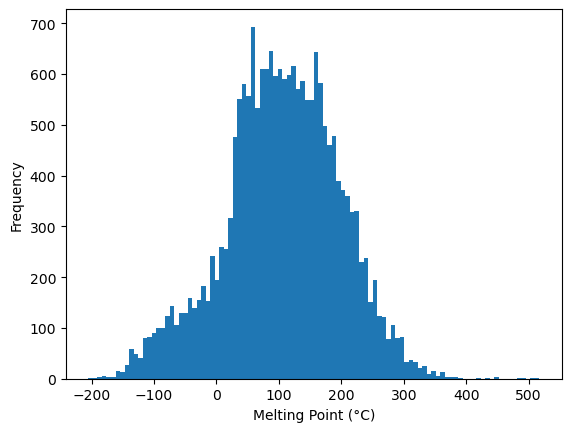

Average melting point: 105.2089275507646


In [11]:
# See the distribution of the melting points using seaborn
plt.hist(final_dataset['mpC'], bins=100)
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.show()

# Print the average melting point
print(f"Average melting point: {final_dataset['mpC'].mean()}")


Now, let's see how it looks without Hbond/polarized bonds. We could calculate the HbondDonnor and HbondAcceptor descriptor to be more accurate, but we will simplify here and remove all molecules containing O, N, F atoms with the remove_unwanted_atoms function.

In [12]:
no_Hbond_df = sc.remove_unwanted_atoms(final_dataset, ['O', 'N', 'F'], "smiles")

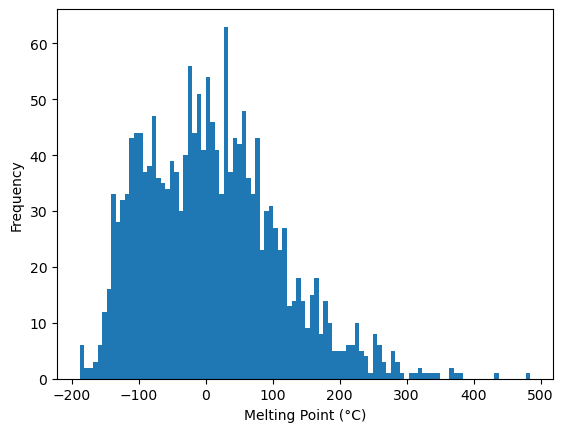

Average melting point: 9.784016949152543


In [13]:
# See the distribution of the melting points
plt.hist(no_Hbond_df['mpC'], bins=100)
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.show()

# Print the average melting point
print(f"Average melting point: {no_Hbond_df['mpC'].mean()}")

As expected, these kind of compounds have a much lower melting point.

We will use features for the training. **The moleculAR package**(name to change) provide functions to compute rdkit/mordred descriptors, or different types of fingerprint. Let's analyze how the rdkit descriptors correlate with the melting point.<br>
<br>
The following function to calculate all 200 rdkit descriptors has already been run and the results are in the data files, we can simply load them :

In [14]:
"""
# Calculate the RDKit descriptors
df_descriptors = featurization.RDkit_descriptors(final_dataset, 'smiles')

#Save the results in a csv file
df_descriptors.to_csv('../data/200rdkit_desc.csv', index=False)
"""
# Load the RDKit descriptors dataset
df_descriptors = pd.read_csv('../data/200rdkit_desc.csv')

In [15]:
df_descriptors.head(5)

,smiles,mpC,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,10.949337,-0.655211,10.949337,0.259075,0.619888,259.221,250.149,259.059306,...,0,0,0,0,0,0,0,0,0,0
1,c1ccc(c(c1)N)N2CCCCC2,46.0,5.909724,0.906852,5.909724,0.906852,0.664933,176.263,160.135,176.131349,...,0,0,0,0,0,0,0,0,0,0
2,c1cnc(nc1)N2CCNCC2,33.0,4.189444,0.846296,4.189444,0.846296,0.628312,164.212,152.116,164.106196,...,0,0,0,0,0,0,0,0,0,0
3,c1ccc(c(c1)N2CCNCC2)O,125.0,9.600688,0.379074,9.600688,0.379074,0.667456,178.235,164.123,178.110613,...,0,0,0,0,0,0,0,0,0,0
4,C1CCC(=CC1)CCN,-55.0,5.418520,0.825231,5.418520,0.825231,0.559754,125.215,110.095,125.120449,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Display the top 3 descriptors correlated with the melting point
features = df_descriptors.drop(columns=['smiles', 'mpC'])
target = df_descriptors['mpC']
correlation = features.corrwith(target)
correlation = correlation.abs().sort_values(ascending=False)
correlation.head(3)

BertzCT      0.568399
RingCount    0.533590
TPSA         0.522911
dtype: float64

The 3 most correlated descriptors are BertzCT, RingCount and TPSA. Let's plot plot the melting point as a function BertzCT wich is continuous and the RingCount wich is discret.

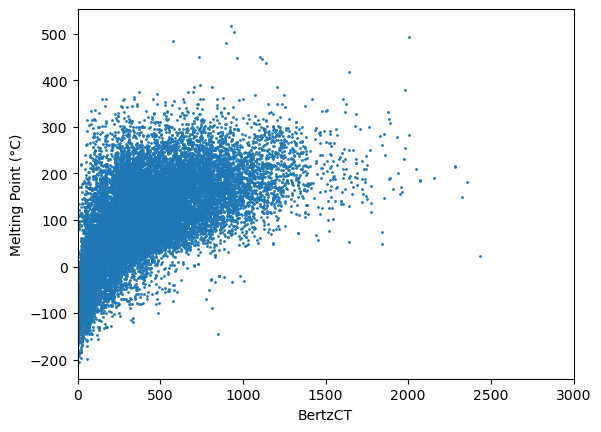

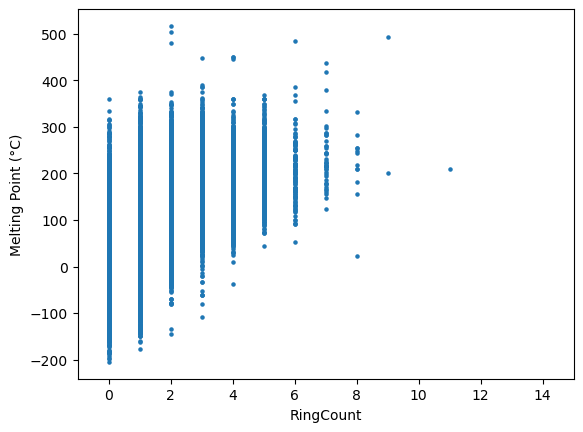

In [17]:
# Plot BertzCT vs Melting Point
plt.scatter(df_descriptors['BertzCT'], df_descriptors['mpC'], s=1)
plt.xlabel('BertzCT')
# Range of the x-axis
plt.xlim(0, 3000)
plt.ylabel('Melting Point (°C)')
plt.show()

# Plot RingCount vs Melting Point
plt.scatter(df_descriptors['RingCount'], df_descriptors['mpC'], s=5)
plt.xlabel('RingCount')
plt.xlim(-1, 15)
plt.ylabel('Melting Point (°C)')
plt.show()

Here we identify another expected trend : the melting point tends to rise with the ring count. Even more, the ring count seems to define a range of possible value for the melting point.

## Featurization

In order to train a model, we need features for each smiles. We have here 2 main choices :
- Descriptors : mordred or rdkit
- Fingerprints : Morgan, MACCS, Topological

Here, we will try all type of fingerprint and only rdkit descriptors because generate mordred descriptors is computationally very demanding as there is more than 1800 different descriptors. 

As the following functions take time to execute, this has already been done and the results are in the “data” folder, we'll just load them.

In [18]:
"""
# Calculate the RDKit descriptors
rdkit_desc = featurization.RDkit_descriptors(final_dataset, 'smiles')

# Generate the 3 types of fingerprints
morgan_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='Morgan', n_bits=2048)
maccs_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='MACCS', n_bits=2048)
topo_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='Topological', n_bits=2048)

# Save the results in a csv file
rdkit_desc.to_csv('../data/200rdkit_desc.csv', index=False)
morgan_fgp.to_csv('../data/morgan_fgp.csv', index=False)
maccs_fgp.to_csv('../data/maccs_fgp.csv', index=False)
topo_fgp.to_csv('../data/topo_fgp.csv', index=False)
"""

# Load the datasets
rdkit_desc = pd.read_csv('../data/200rdkit_desc.csv')
morgan_fgp = pd.read_csv('../data/morgan_fgp.csv')
maccs_fgp = pd.read_csv('../data/maccs_fgp.csv')
topo_fgp = pd.read_csv('../data/topo_fgp.csv')

We can define our different features(X) and the target(y) for the training :

In [19]:
# Separe mpC and smiles from datasets
y = final_dataset['mpC']
# Drop the mpC and smiles columns to only keep the features
X_rdkit = rdkit_desc.drop(columns=['smiles', 'mpC'])
X_morgan_fgp = morgan_fgp.drop(columns=['smiles', 'mpC'])
X_maccs_fgp = maccs_fgp.drop(columns=['smiles', 'mpC'])
X_topo_fgp = topo_fgp.drop(columns=['smiles', 'mpC'])

Now we have to look if one of the feature dataset contains NaN values, this can cause trouble for the model training

In [20]:
# See if the datasets have NaN values
print(f"rdkit_desc as {X_rdkit.isna().sum().sum()} NaN values")
print(f"X_morgan_fgp as {X_morgan_fgp.isna().sum().sum()} NaN values")
print(f"X_maccs_fgp as {X_maccs_fgp.isna().sum().sum()} NaN values")
print(f"X_topo_fgp as {X_topo_fgp.isna().sum().sum()} NaN values")

rdkit_desc as 72 NaN values
X_morgan_fgp as 0 NaN values
X_maccs_fgp as 0 NaN values
X_topo_fgp as 0 NaN values


We see that the rdkit_desc contains NaN values. There's many different ways to handle NaN values in machine learning, here we will use the handle_missing_data function with a threshold of 0.8 and the fill method "mean". (see the function to understand)

In [21]:
X_rdkit = fc.handle_missing_data(X_rdkit, threshold=0.8, fill_method="mean")

Also, we can clean the features to make the training faster. Removing low variance and highly correlated features should not have a significant impact on the model performance because it is redondant informations  :

In [33]:
X_rdkit_novar = fc.remove_low_variance_features(X_rdkit, excluded_cols = [])
X_morgan_fgp_novar = fc.remove_low_variance_features(X_morgan_fgp, excluded_cols = [])
X_maccs_fgp_novar = fc.remove_low_variance_features(X_maccs_fgp, excluded_cols = [])
X_topo_fgp_novar = fc.remove_low_variance_features(X_topo_fgp, excluded_cols = [])

## Model training

In [34]:
rdkit_perf = rm.compare_regression_models(X_rdkit, y)
rdkit_perf

,R2 Score,RMSE
XGBoost,0.802351,40.761519
LightGBM,0.800431,40.959035
Random Forest,0.795193,41.493067
Gradient Boosting,0.750848,45.765174
Linear Regression,0.708182,49.528918


In [27]:
morgan_perf = rm.compare_regression_models(X_morgan_fgp, y,)
morgan_perf

,R2 Score,RMSE
XGBoost,0.709673,49.402233
Random Forest,0.702716,49.990624
LightGBM,0.694995,50.635638
Linear Regression,0.619239,56.575597
Gradient Boosting,0.592711,58.513223


In [32]:
topo_perf = rm.compare_regression_models(X_topo_fgp, y)
topo_perf

,R2 Score,RMSE
XGBoost,0.705098,49.789985
Random Forest,0.703059,49.961822
LightGBM,0.691794,50.900690
Gradient Boosting,0.588845,58.790288
Linear Regression,0.588499,58.815034


In [31]:
maccs_perf = rm.compare_regression_models(X_maccs_fgp, y)
maccs_perf

,R2 Score,RMSE
XGBoost,0.748467,45.983356
Random Forest,0.741392,46.625505
LightGBM,0.736126,47.097854
Gradient Boosting,0.669470,52.711852
Linear Regression,0.642226,54.841234


RandomForest with rdkit descriptors is the best-performing model. Let's see a plot of predictions vs. actual values

R² Score: 0.7950
RMSE: 41.8063


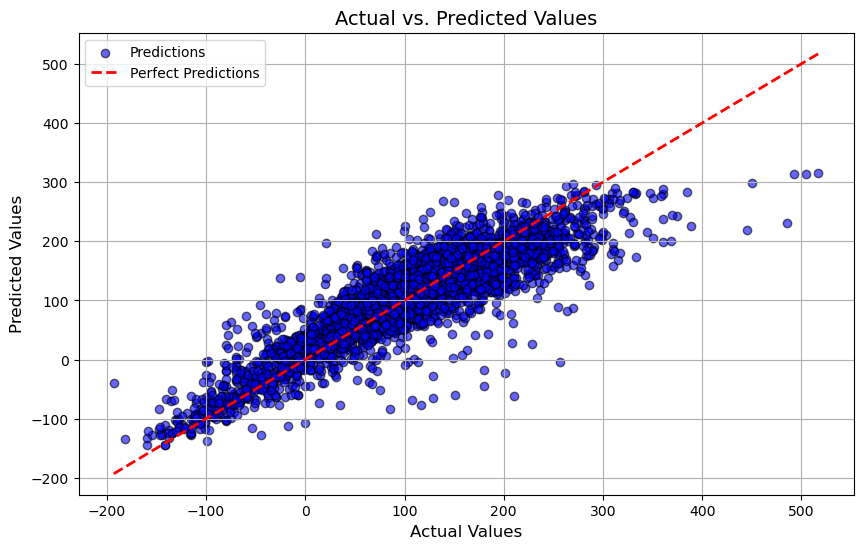

In [36]:
from sklearn.ensemble import RandomForestRegressor
rm.plot_predictions(RandomForestRegressor(), X_rdkit, y, test_size=0.2, random_state = 42)

After this, an hyperparameter tunning using a GridSearch has been done for RandomForest with rdkit descriptors but no significant improvement has been observed.

Another model was trained using chemprop (https://github.com/chemprop/chemprop). The full data (corresponding to bradleymeltingpoint cleaned) and data splitting are in the "data" folder. The training was done using the default arguments with *"--features_generator rdkit_2d_normalized --no_features_scaling"* in addition. The best performing epoch was epoch 26/30 with a RMSE of 37.84 on the validation set and of 36.11 on the test set.
As this model is the best performing one, it was chosen as the one to be implemented in the interface and evaluated in greater depth in the second notebook.

    --data_path <data_path> --dataset_type regression --save_dir <save_dir> --split_sizes 0.8 0.1 0.1 --save_smiles_splits --features_generator rdkit_2d_normalized --no_features_scaling 


**test rmse = 36.106023**

___
Then, another training has been done with 3-fold validation using the additional argument : 

	--num_folds 3



**Seed 0 ==> test rmse = 35.984399**

**Seed 1 ==> test rmse = 36.522956**

**Seed 2 ==> test rmse = 35.771262**

This allows us to assert that the model's performance is not "splitting specific".